In [14]:
# Install required packages
!pip install medmnist
!pip install ipywidgets IProgress
!pip install torchfusion

import torch
import torch.cuda as cuda
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.utils as utils
import medmnist
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Image
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from medmnist import INFO, Evaluator
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
device = torch.device("cuda")
l2_lambda = 0.01

In [16]:
class CNN(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(CNN, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc = nn.Sequential(
        nn.Linear(64 * 4 * 4, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )
    self.dropout = nn.Dropout(p=0.5)
  def forward(self, x):
    x = self.features(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

In [27]:
class classification():
  def __init__(self, n_channels, n_classes, learning_rate):
    self.model = CNN(in_channels=n_channels, num_classes=n_classes).cuda()
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self. model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=l2_lambda)
    self.train_accuracy_per_epoch = []
    self.train_loss_per_epoch = []
    self.val_accuracy_per_epoch = []
    self.val_loss_per_epoch = []
    self.test_accuracy_per_epoch = []
    self.test_loss_per_epoch = []
    self.patience = 5
    self.test_accuracy_end = None
    self.test_loss_end = None
    self.best_val_loss = float('inf')
    self.counter = 0
  def test(self, test,flag =1):
    self.model.eval()
    y_true = torch.tensor([]).cuda()
    y_score = torch.tensor([]).cuda()
    loss = 0
    with torch.no_grad():
      for inputs, targets in test:
        outputs = self.model(inputs.cuda())
        targets = targets.squeeze().long().cuda()
        loss+= self.criterion(outputs, targets)
        outputs = outputs.softmax(dim=-1).cuda()
        targets = targets.float().resize_(len(targets), 1)
        y_true = torch.cat((y_true, targets), 0)
        y_score = torch.cat((y_score, outputs), 0)
      y_preds = torch.argmax(y_score, 1)
      y_true = y_true.detach().cpu().numpy()
      y_score = y_score.detach().cpu().numpy()
      if flag==1:
        split="test"
      else:
        split="val"
      evaluator = Evaluator("octmnist",split)
      metrics = evaluator.evaluate(y_score)
    accuracy = metrics[1]
    print(split+" accuracy" ,accuracy)
    print(split+" loss" ,loss/len(test))
    if flag==1:
      return accuracy, y_true, y_preds, loss/len(test)
    else:
      return accuracy, loss/len(test)
  def train(self, train, val, epochs):
    for epoch in range(epochs):
      self.model.train()
      print(epoch,"epoch")
      correct ,total = 0,0
      total_loss = 0
      for inputs, targets in tqdm(train):
          self.optimizer.zero_grad()
          outputs = self.model(inputs.cuda())
          targets = targets.squeeze().long().cuda()
          loss = self.criterion(outputs, targets)
          total_loss += loss
          loss.backward()
          self.optimizer.step()
          correct+= sum(targets == torch.argmax(outputs, 1))
          total += len(outputs)
      self.train_accuracy_per_epoch.append(correct.item()/total)
      self.train_loss_per_epoch.append(total_loss.cpu().detach().numpy()/total)
      print("train accuracy",correct.item()/total)
      print("train loss", total_loss/total)
      val_acc,val_loss = self.test(val,0)
      self.val_accuracy_per_epoch.append(val_acc)
      self.val_loss_per_epoch.append(val_loss.cpu().numpy())
      if val_loss < self.best_val_loss:
        self.best_val_loss = val_loss
        self.counter = 0
      else:
        self.counter += 1
        if self.counter >= self.patience:
            print("Early stopping!")
            break
      test_accuracy, y_true,y_pred , loss = self.test(test=test_loader)
      self.test_accuracy_per_epoch.append(test_accuracy)
      self.test_loss_per_epoch.append(loss.cpu().numpy())
      cm = confusion_matrix(y_true.tolist(), y_pred.tolist())
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      plt.figure(figsize=(5,5))
      disp.plot()
      plt.xticks(rotation=90)
      plt.show()


In [18]:
def plot_accuracy(training, validation, test):
    plt.figure(figsize=(9, 4))
    plt.plot(training)
    plt.plot(validation)
    plt.plot(test)
    plt.title("Training & Validation & Test Accuracy per Epoch")
    plt.legend(["Training Accuracy", "Validation Accuracy",
                "Test Accuracy"])
    plt.show()

def plot_loss(training, validation, test):
    plt.figure(figsize=(9, 4))
    plt.plot(training)
    plt.plot(validation)
    plt.plot(test)
    plt.title("Training & Validation & Test loss per Epoch")
    plt.legend(["Training loss", "Validation loss",
                "Test loss"])
    plt.show()


In [19]:
batch_size=128
info = INFO["octmnist"]
data_transform_valtest = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])
        ])
data_transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])
        ])
channels = info["n_channels"]
classes = len(info["label"])
DataClass = getattr(medmnist, info["python_class"])
train_dataset = DataClass(split="train", transform=data_transform_train, download=True)
val_dataset = DataClass(split="val", transform=data_transform_valtest, download=True)
test_dataset = DataClass(split="test", transform=data_transform_valtest, download=True)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


0 epoch


100%|██████████| 762/762 [00:30<00:00, 24.71it/s]


train accuracy 0.7302850928937082
train loss tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.767817577548006
val loss tensor(0.6941, device='cuda:0')
test accuracy 0.465
test loss tensor(1.4994, device='cuda:0')


<Figure size 500x500 with 0 Axes>

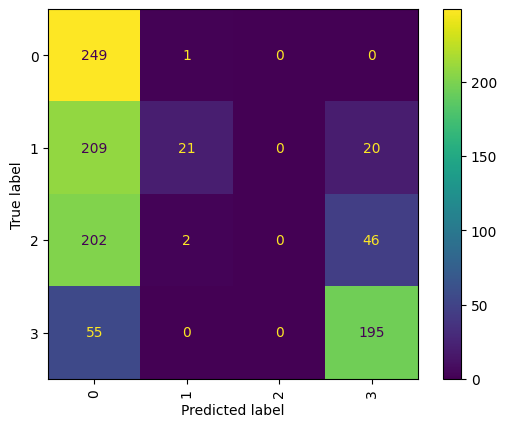

1 epoch


100%|██████████| 762/762 [00:28<00:00, 26.54it/s]


train accuracy 0.8351508560993876
train loss tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8533050221565731
val loss tensor(0.4335, device='cuda:0')
test accuracy 0.672
test loss tensor(0.7779, device='cuda:0')


<Figure size 500x500 with 0 Axes>

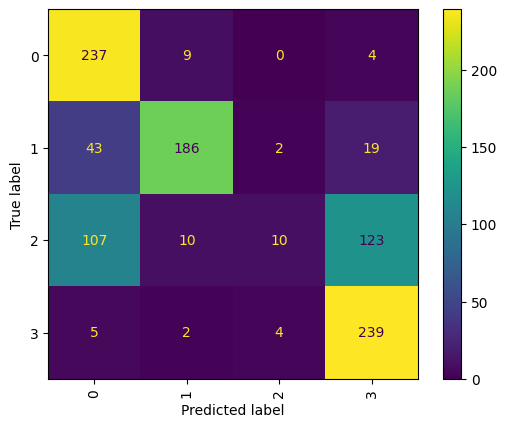

2 epoch


100%|██████████| 762/762 [00:29<00:00, 25.55it/s]


train accuracy 0.8547759984406578
train loss tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8636447562776958
val loss tensor(0.3932, device='cuda:0')
test accuracy 0.63
test loss tensor(0.8540, device='cuda:0')


<Figure size 500x500 with 0 Axes>

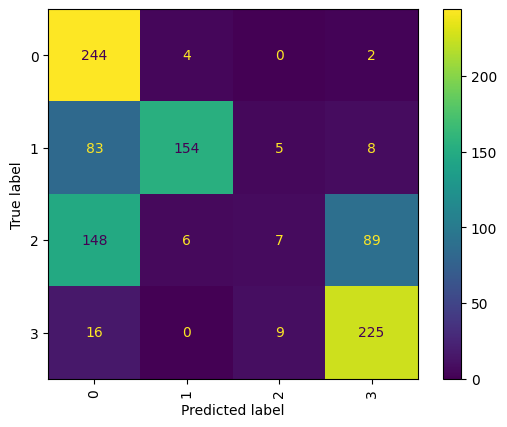

3 epoch


100%|██████████| 762/762 [00:28<00:00, 26.66it/s]


train accuracy 0.8668403828595463
train loss tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8594903988183161
val loss tensor(0.4193, device='cuda:0')
test accuracy 0.654
test loss tensor(0.8281, device='cuda:0')


<Figure size 500x500 with 0 Axes>

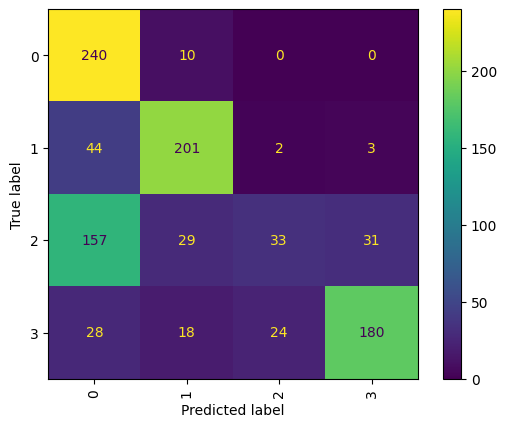

4 epoch


100%|██████████| 762/762 [00:28<00:00, 26.49it/s]


train accuracy 0.8757142710588138
train loss tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8755539143279173
val loss tensor(0.3663, device='cuda:0')
test accuracy 0.709
test loss tensor(0.7643, device='cuda:0')


<Figure size 500x500 with 0 Axes>

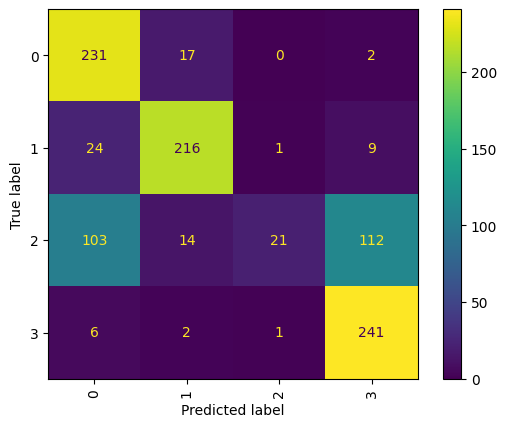

5 epoch


100%|██████████| 762/762 [00:29<00:00, 25.71it/s]


train accuracy 0.8830493347148558
train loss tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8882939438700148
val loss tensor(0.3220, device='cuda:0')
test accuracy 0.7
test loss tensor(0.7977, device='cuda:0')


<Figure size 500x500 with 0 Axes>

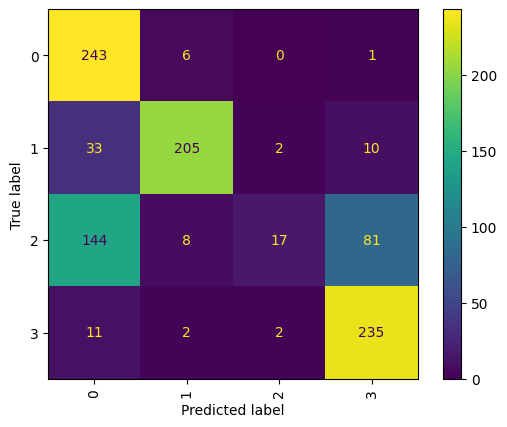

6 epoch


100%|██████████| 762/762 [00:29<00:00, 26.01it/s]


train accuracy 0.8886403972219088
train loss tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8814623338257016
val loss tensor(0.3491, device='cuda:0')
test accuracy 0.729
test loss tensor(0.7360, device='cuda:0')


<Figure size 500x500 with 0 Axes>

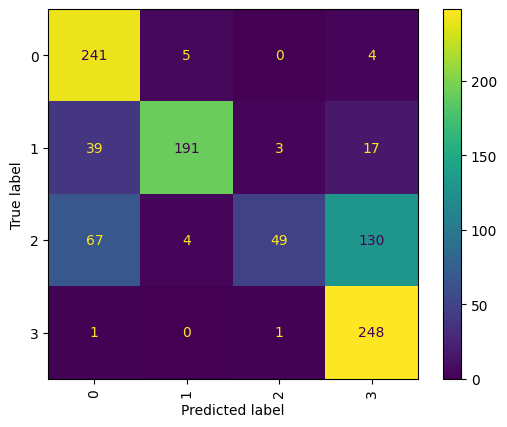

7 epoch


100%|██████████| 762/762 [00:29<00:00, 25.74it/s]


train accuracy 0.8934928239482134
train loss tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8900480059084195
val loss tensor(0.3209, device='cuda:0')
test accuracy 0.732
test loss tensor(0.7232, device='cuda:0')


<Figure size 500x500 with 0 Axes>

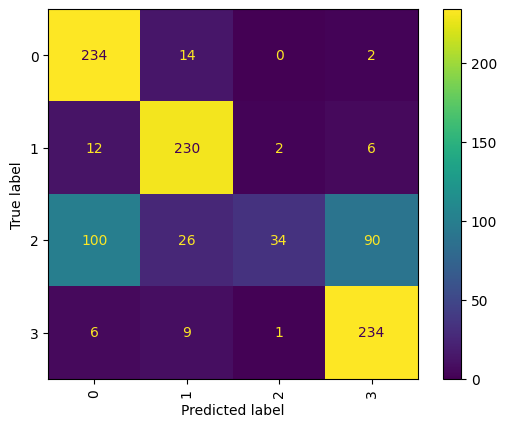

8 epoch


100%|██████████| 762/762 [00:29<00:00, 25.96it/s]


train accuracy 0.8971347087005139
train loss tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8692762186115214
val loss tensor(0.4101, device='cuda:0')
test accuracy 0.71
test loss tensor(0.8851, device='cuda:0')


<Figure size 500x500 with 0 Axes>

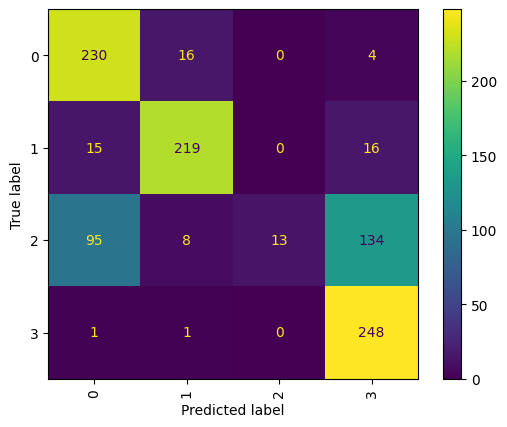

9 epoch


100%|██████████| 762/762 [00:29<00:00, 25.53it/s]


train accuracy 0.9005406403561866
train loss tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8874630723781388
val loss tensor(0.3266, device='cuda:0')
test accuracy 0.744
test loss tensor(0.6475, device='cuda:0')


<Figure size 500x500 with 0 Axes>

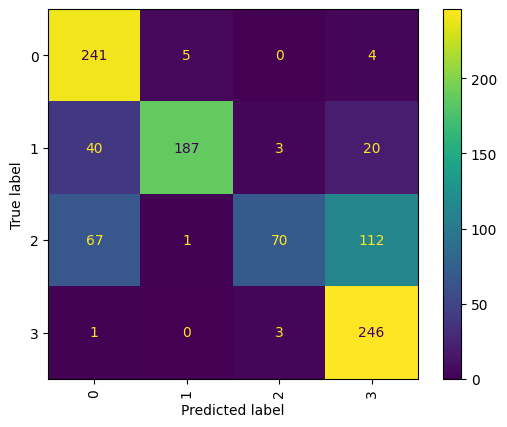

10 epoch


100%|██████████| 762/762 [00:30<00:00, 24.80it/s]


train accuracy 0.9028796536618895
train loss tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.899649187592319
val loss tensor(0.2930, device='cuda:0')
test accuracy 0.707
test loss tensor(0.8261, device='cuda:0')


<Figure size 500x500 with 0 Axes>

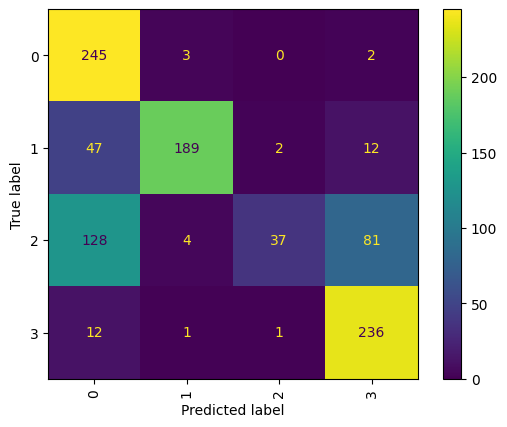

11 epoch


100%|██████████| 762/762 [00:30<00:00, 24.91it/s]


train accuracy 0.9059573027483406
train loss tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.90352658788774
val loss tensor(0.2825, device='cuda:0')
test accuracy 0.755
test loss tensor(0.6533, device='cuda:0')


<Figure size 500x500 with 0 Axes>

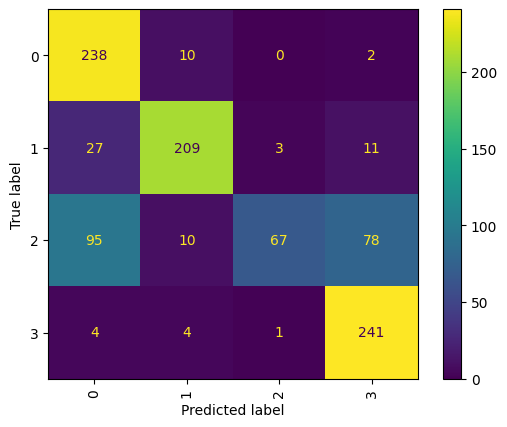

12 epoch


100%|██████████| 762/762 [00:30<00:00, 25.03it/s]


train accuracy 0.9080398452968392
train loss tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.9061115214180206
val loss tensor(0.2767, device='cuda:0')
test accuracy 0.722
test loss tensor(0.7389, device='cuda:0')


<Figure size 500x500 with 0 Axes>

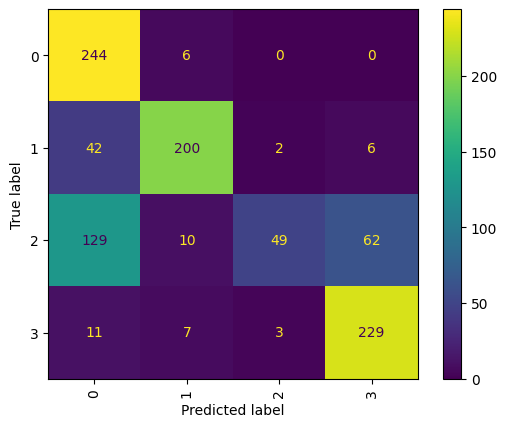

13 epoch


100%|██████████| 762/762 [00:29<00:00, 25.98it/s]


train accuracy 0.9093324579131488
train loss tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.8954948301329394
val loss tensor(0.3060, device='cuda:0')
test accuracy 0.668
test loss tensor(0.9096, device='cuda:0')


<Figure size 500x500 with 0 Axes>

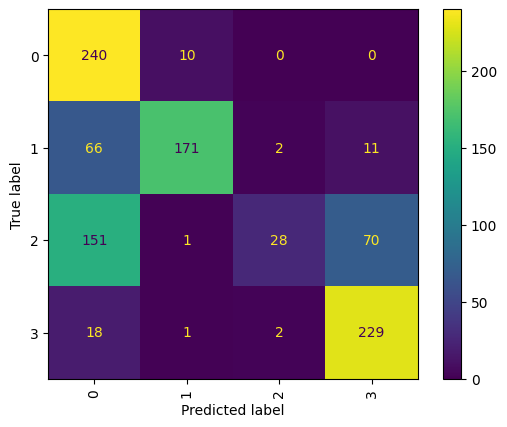

14 epoch


100%|██████████| 762/762 [00:29<00:00, 25.69it/s]


train accuracy 0.9116406947279871
train loss tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.902788035450517
val loss tensor(0.2848, device='cuda:0')
test accuracy 0.748
test loss tensor(0.6710, device='cuda:0')


<Figure size 500x500 with 0 Axes>

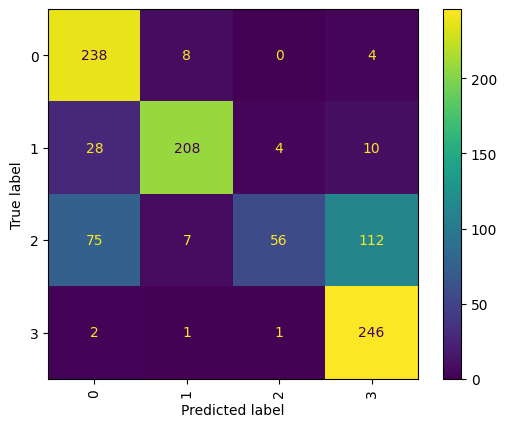

15 epoch


100%|██████████| 762/762 [00:29<00:00, 25.74it/s]


train accuracy 0.9142566964514706
train loss tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.9013109305760709
val loss tensor(0.2864, device='cuda:0')
test accuracy 0.68
test loss tensor(0.8528, device='cuda:0')


<Figure size 500x500 with 0 Axes>

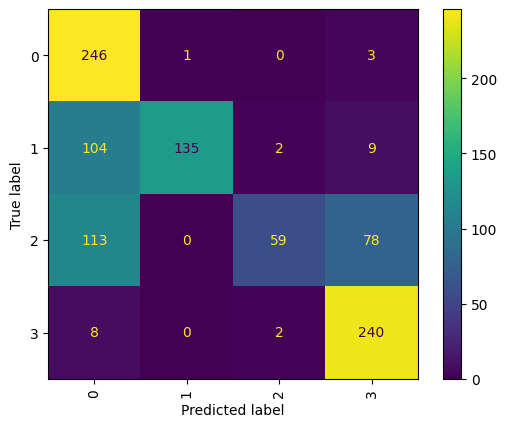

16 epoch


100%|██████████| 762/762 [00:30<00:00, 25.19it/s]


train accuracy 0.9150876617048124
train loss tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.901218611521418
val loss tensor(0.3006, device='cuda:0')
test accuracy 0.716
test loss tensor(0.8030, device='cuda:0')


<Figure size 500x500 with 0 Axes>

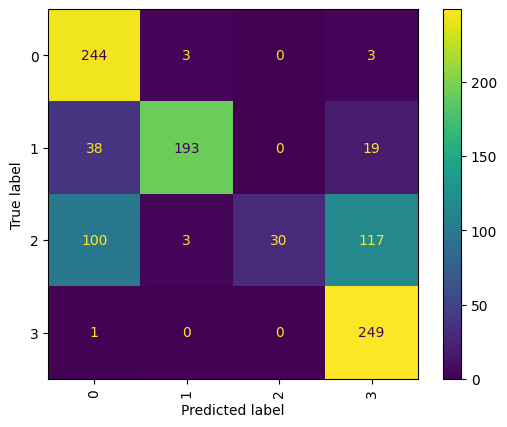

17 epoch


100%|██████████| 762/762 [00:30<00:00, 24.97it/s]


train accuracy 0.915364650122593
train loss tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val accuracy 0.9078655834564254
val loss tensor(0.2830, device='cuda:0')
Early stopping!


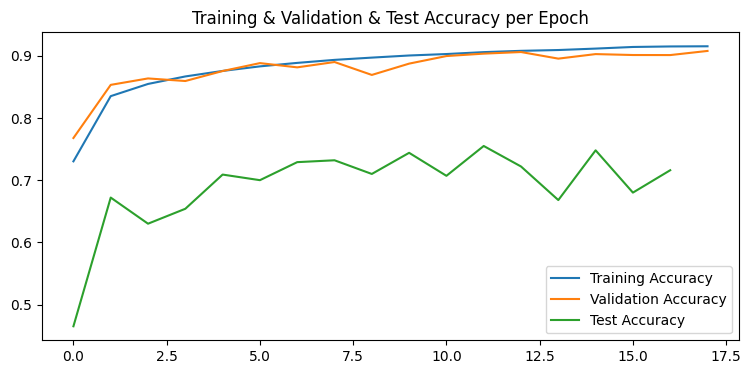

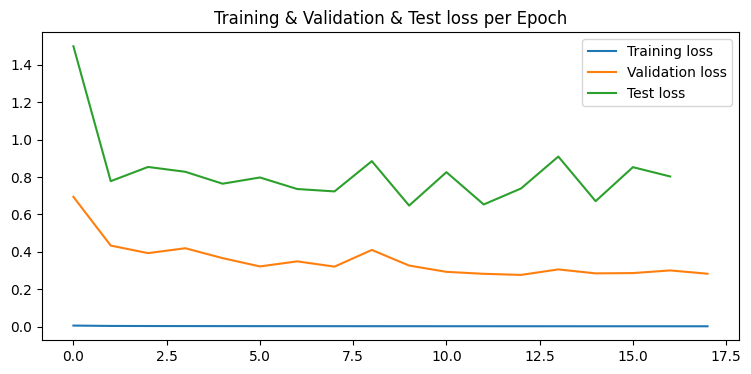

test accuracy 0.709
test loss tensor(0.7364, device='cuda:0')
Precision: 0.7681848196424106
Recall: 0.7090000000000001
F1 Score: 0.6760119683544141


In [31]:
epochs = 20
obj = classification(n_channels=channels, n_classes=classes,learning_rate=0.001)
obj.train(train=train_loader, val=val_loader, epochs=epochs)
plot_accuracy(obj.train_accuracy_per_epoch, obj.val_accuracy_per_epoch, obj.test_accuracy_per_epoch)
plot_loss(obj.train_loss_per_epoch, obj.val_loss_per_epoch, obj.test_loss_per_epoch)

test_accuracy, y_true,y_pred , loss = obj.test(test=test_loader)
precision = precision_score(y_true.tolist(), y_pred.tolist(),average='macro')
recall = recall_score(y_true.tolist(), y_pred.tolist(),average='macro')
f1 = f1_score(y_true.tolist(), y_pred.tolist(),average='macro')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
torch.save(obj.model.state_dict(),f"model_epochs{epochs}.pth")
import pickle
with open("model.pkl","wb") as f:
  pickle.dump(obj.model.state_dict(),f)


